In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
import gc
import os

from tsfresh.feature_extraction import extract_features
from tqdm import tqdm

In [2]:
train_meta = pd.read_csv("../input/metadata_train.csv")
test_meta = pd.read_csv("../input/metadata_test.csv")
train_meta.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [3]:
test_meta.head()

,signal_id,id_measurement,phase
0,8712,2904,0
1,8713,2904,1
2,8714,2904,2
3,8715,2905,0
4,8716,2905,1


## Watch Metadata

In [6]:
train_meta.phase.value_counts()

2    2904
1    2904
0    2904
Name: phase, dtype: int64

In [7]:
train_meta.id_measurement.max()

2903

In [8]:
train_meta.target.mean()

0.060261707988980714

In [11]:
train_meta.query("target == 1").phase.value_counts()

2    181
0    178
1    166
Name: phase, dtype: int64

## Parquet

In [5]:
train = pq.read_pandas("../input/train.parquet").to_pandas()
train.head()

,0,1,2,3,4,5,6,7,8,9,...,8702,8703,8704,8705,8706,8707,8708,8709,8710,8711
0,18,1,-19,-16,-5,19,-15,15,-1,-16,...,18,-22,12,8,13,6,-21,-15,-9,20
1,18,0,-19,-17,-6,19,-17,16,0,-15,...,17,-21,12,8,14,7,-19,-15,-8,21
2,17,-1,-20,-17,-6,19,-17,15,-3,-15,...,16,-21,13,8,15,8,-18,-14,-8,22
3,18,1,-19,-16,-5,20,-16,16,0,-15,...,16,-21,12,8,15,8,-19,-14,-7,23
4,18,0,-19,-16,-5,20,-17,16,-2,-14,...,17,-22,12,8,15,8,-18,-14,-8,23


In [6]:
gc.collect()

8733

In [15]:
train = train.T
gc.collect()

0

In [24]:
def draw_plots(parq, meta):
    neg_idx = meta.query("target == 0 & phase == 0").sample(1).index.values
    pos_idx = meta.query("target == 1 & phase == 0").sample(1).index.values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
    for p in range(3):
        sns.lineplot(x=parq.columns, y=parq.iloc[neg_idx[0]+p, :], ax=ax1, label=[
            "phase:" + str(meta.iloc[neg_idx[0]+p, :].phase)])
        sns.lineplot(x=parq.columns, y=parq.iloc[pos_idx[0]+p, :], ax=ax2, label=[
            "phase:" + str(meta.iloc[pos_idx[0]+p, :].phase)])
    ax1.set_xlabel("undamaged signal", fontsize=18)
    ax1.set_ylabel("amp", fontsize=18)
    ax1.patch.set_facecolor("blue")
    ax1.patch.set_alpha(0.2)
    ax2.set_xlabel("damaged signal", fontsize=18)
    ax2.set_ylabel("amp", fontsize=18)
    ax2.patch.set_facecolor("red")
    ax2.patch.set_alpha(0.2)
    plt.show()

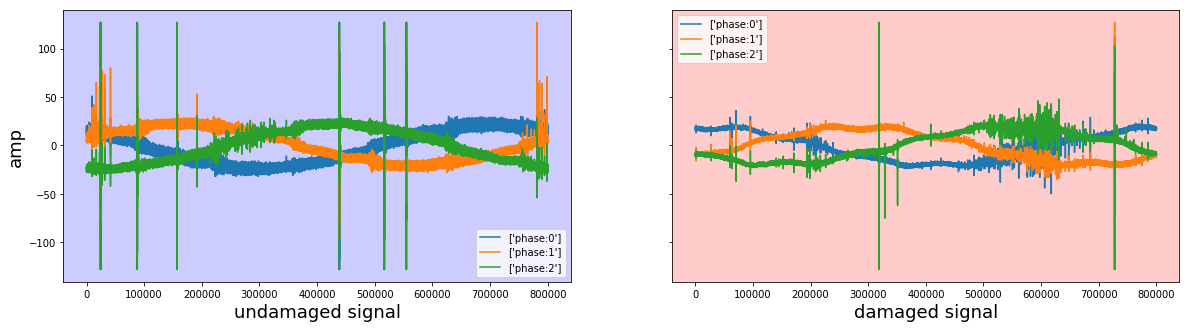

In [25]:
draw_plots(train, train_meta)

In [26]:
def min_max_transf(ts, min_data, max_data, range_needed=(-1, 1)):
    if min_data < 0:
        ts_std = (ts + abs(min_data)) / (max_data + abs(min_data))
    else:
        ts_std = (ts - min_data) / (max_data - min_data)
    if range_needed[0] < 0:
        return ts_std * (range_needed[1] + abs(range_needed[0])) + range_needed[0]
    else:
        return ts_std * (range_needed[1] - range_needed[0]) + range_needed[0]

In [35]:
def transform_ts(ts, n_dim=160, min_max=(-1, 1)):
    ts_std = min_max_transf(ts, min_data=-128, max_data=127)
    sample_size = ts.shape[1]
    bucket_size = int(sample_size / n_dim)
    new_ts = []
    for i in range(0, sample_size, bucket_size):
        ts_range = ts_std[i:i+bucket_size]
        mean = ts_range.mean()
        std = ts_range.std()
        std_top = mean + std
        std_bot = mean - std
        percentil_calc = np.percentile(ts_range, [0, 1, 25, 50, 75, 99, 100])
        max_range = percentil_calc[-1] - percentil_calc[0]
        import ipdb
        ipdb.set_trace()
        
        relative_percentile = percentil_calc - mean
        new_ts.append(np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]),
                                      percentil_calc, relative_percentile]))
    return np.asarray(new_ts)

In [ ]:
transform_ts(train.iloc[0:2, :])

> <ipython-input-35-f06fe959b945>(17)transform_ts()
     16 
---> 17         relative_percentile = percentil_calc - mean
     18         new_ts.append(np.concatenate([np.asarray([mean, std, std_top, std_bot, max_range]),



ipdb>  ts_range


     0         1         2         ...       799997    799998    799999
0  0.145098  0.145098  0.137255    ...     0.137255  0.152941  0.137255
1  0.011765  0.003922 -0.003922    ...     0.003922  0.011765  0.003922

[2 rows x 800000 columns]


ipdb>  sample_size


800000


ipdb>  bucket_size


5000


ipdb>  i


0


ipdb>  ts_std[0:5000]


     0         1         2         ...       799997    799998    799999
0  0.145098  0.145098  0.137255    ...     0.137255  0.152941  0.137255
1  0.011765  0.003922 -0.003922    ...     0.003922  0.011765  0.003922

[2 rows x 800000 columns]


## tsfresh

In [7]:
train.shape

(800000, 8712)

In [8]:
bucket_size = int(800000 / 500)
idx = np.array([i for i in range(500) for _ in range(bucket_size)])

In [9]:
idx

array([  0,   0,   0, ..., 499, 499, 499])

In [10]:
train["dummy_idx"] = idx

In [11]:
gc.collect()

0

In [16]:
extract_features(train, column_value="1", n_jobs=2, column_id="dummy_idx", default_fc_parameters={
    "fft_coefficient": [
        {"coeff": 0, "attr": "abs"},
        {"coeff": 1, "attr": "abs"},
        {"coeff": 2, "attr": "abs"}
    ]
})


Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 82.42it/s]

variable,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""","1__fft_coefficient__coeff_2__attr_""abs"""
id,,,
0,311.0,14561.225781,72.370046
1,486.0,14553.451413,40.480055
2,495.0,14621.488234,57.794441
3,339.0,14644.829578,34.026975
4,76.0,14599.800521,13.743955
5,157.0,14566.616493,85.975949
6,407.0,14565.999781,46.070500
7,485.0,14610.705329,41.668559
8,475.0,14664.577901,57.505438


In [2]:
def load_parquet(path="../input/train.parquet", ncols=1452):
    nrows = 800000 * ncols
    parq_mat = np.zeros((nrows, 3))

    bucket_size = int(800000 / 160)
    idx = np.repeat(range(160), bucket_size)
    dummy = np.tile(idx, ncols).reshape(-1, 1)
    
    group = np.repeat(range(ncols), 800000).reshape(-1, 1)
    
    parq_mat = np.concatenate([parq_mat, dummy, group], axis=1)
    del dummy, group
    gc.collect()
    
    parq = pq.read_pandas(path, columns=["0", "1", "2"]).to_pandas().values
    parq_mat[0:800000, 0:3] = parq

    for i in tqdm(range(1, ncols)):
        temp = pq.read_pandas(path, columns=[str(i), str(i+1), str(i+2)]).to_pandas().values
        parq_mat[i*800000:(i+1)*800000, 0:3] = temp
    del temp
    gc.collect()
    parq = pd.DataFrame(parq_mat, columns=[
        "phase0", "phase1", "phase2", "dummy", "group"
    ])
    feats = extract_features(
        parq,
        column_id="dummy",
        column_kind="group",
        column_value="phase0",
        n_jobs=2,
        default_fc_parameters={
            "fft_coefficient": [
                {"coeff": 0, "attr": "abs"},
                {"coeff": 1, "attr": "abs"}
            ]
        })
    return feats

In [9]:
params = {
            'longest_strike_above_mean': None,
            'longest_strike_below_mean': None,
            'mean_change': None,
            'mean_abs_change': None,
            'length': None,
            'mean': None,
            'maximum': None,
            'minimum': None,
            # additional
            'absolute_sum_of_changes': None,
            'autocorrelation': [{'lag': 3}],
            'binned_entropy': [{'max_bins': 10}],
            'cid_ce': [{'normalize': True}],
            'count_above_mean': None,
            'first_location_of_maximum': None,
            'first_location_of_minimum': None,
            'last_location_of_maximum': None,
            'last_location_of_minimum': None,
            'mean_second_derivative_central': None,
            'median': None,
            'ratio_beyond_r_sigma': [{'r': 2}],
            'sample_entropy': None,
            'time_reversal_asymmetry_statistic': [{'lag': 4}]
        }

In [10]:
n_feats = 0
for v in params.values():
    if isinstance(v, list):
        n_feats += len(v)
    else:
        n_feats += 1
n_feats

22

In [3]:
encoded = load_parquet(ncols=100)
encoded.head()

Feature Extraction: 100%|██████████| 10/10 [00:19<00:00,  1.92s/it]


variable,"0.0__fft_coefficient__coeff_0__attr_""abs""","0.0__fft_coefficient__coeff_1__attr_""abs""","1.0__fft_coefficient__coeff_0__attr_""abs""","1.0__fft_coefficient__coeff_1__attr_""abs""","10.0__fft_coefficient__coeff_0__attr_""abs""","10.0__fft_coefficient__coeff_1__attr_""abs""","11.0__fft_coefficient__coeff_0__attr_""abs""","11.0__fft_coefficient__coeff_1__attr_""abs""","12.0__fft_coefficient__coeff_0__attr_""abs""","12.0__fft_coefficient__coeff_1__attr_""abs""",...,"95.0__fft_coefficient__coeff_0__attr_""abs""","95.0__fft_coefficient__coeff_1__attr_""abs""","96.0__fft_coefficient__coeff_0__attr_""abs""","96.0__fft_coefficient__coeff_1__attr_""abs""","97.0__fft_coefficient__coeff_0__attr_""abs""","97.0__fft_coefficient__coeff_1__attr_""abs""","98.0__fft_coefficient__coeff_0__attr_""abs""","98.0__fft_coefficient__coeff_1__attr_""abs""","99.0__fft_coefficient__coeff_0__attr_""abs""","99.0__fft_coefficient__coeff_1__attr_""abs"""
id,,,,,,,,,,,,,,,,,,,,,
0.0,88805.0,355.711617,2922.0,203.587158,49563.0,1135.404756,112659.0,50.133639,81.0,1224.132455,...,91884.0,262.244416,87944.0,887.660596,96026.0,1016.009484,13908.0,1502.838747,91953.0,720.639852
1.0,87720.0,1128.883610,10987.0,945.722139,54079.0,1107.065396,111078.0,292.879560,7176.0,1124.848844,...,90395.0,194.918668,91143.0,316.217731,89610.0,834.547303,22840.0,1333.372808,95068.0,191.681223
2.0,80788.0,1411.789236,16522.0,943.343152,58456.0,894.208744,110132.0,462.114426,13668.0,797.774825,...,90102.0,100.217836,89587.0,340.663265,86233.0,283.707286,25550.0,342.460510,94015.0,559.464616
3.0,73586.0,881.794514,22865.0,560.398608,62439.0,419.309467,110573.0,690.149834,17999.0,660.061237,...,90935.0,237.070599,90091.0,336.406088,87259.0,378.329174,24588.0,621.869421,92136.0,755.564572
4.0,69658.0,852.453017,25834.0,998.945580,63999.0,528.417558,108490.0,412.781097,22245.0,538.451276,...,92175.0,185.683506,93327.0,840.685835,83774.0,300.518449,31476.0,1446.538045,97818.0,1397.306408


In [2]:
def fresh_features(path="../input/train.parquet",
                   offset=0,
                   ncols=1452,
                   n_dims=160,
                   fc_parameters={}):
    nrows = 800000 * ncols
    pq_mat = np.zeros((nrows, 3))
    bucket_size = int(800000 / n_dims)

    idx = np.repeat(range(n_dims), bucket_size)
    dummy = np.tile(idx, ncols).reshape(-1, 1)
    group = np.repeat(range(ncols), 800000).reshape(-1, 1)
    pq_mat = np.concatenate([pq_mat, dummy, group], axis=1)
    del dummy, group
    gc.collect()

    temp = pq.read_pandas(
        path, columns=[str(offset),
                       str(offset + 1),
                       str(offset + 2)]).to_pandas().values
    pq_mat[0:800000, 0:3] = temp

    for i in tqdm(range(1, ncols)):
        temp = pq.read_pandas(
            path,
            columns=[
                str(offset + i),
                str(offset + i + 1),
                str(offset + i + 2)
            ]).to_pandas().values
        pq_mat[i * 800000:(i + 1) * 800000, 0:3] = temp
    del temp
    gc.collect()
    parq = pd.DataFrame(
        pq_mat, columns=["phase0", "phase1", "phase2", "dummy", "group"])
    n_feats = 0
    for v in fc_parameters.values():
        if isinstance(v, list):
            n_feats += len(v)
        else:
            n_feats += 1
    feat_mat = np.zeros((ncols, n_dims, 3 * n_feats))
    for i in range(3):
        feats = extract_features(
            parq,
            default_fc_parameters=fc_parameters,
            column_id="dummy",
            column_kind="group",
            column_value=f"phase{i}",
            n_jobs=2)
        for j in range(ncols):
            feats_per_cols = feats.filter(
                regex=f"^{float(j)}__").values.reshape((-1, n_dims, n_feats))
            feat_mat[j, :, i * n_feats:(i + 1) * n_feats] = feats_per_cols
    return feat_mat

In [3]:
feats = fresh_features(ncols=100, fc_parameters={
    "fft_coefficient": [
        {"coeff": 0, "attr": "abs"},
        {"coeff": 1, "attr": "abs"}
    ],
    "cid_ce": [{"normalize": True}]
})

Feature Extraction: 100%|██████████| 10/10 [00:34<00:00,  3.55s/it]


In [ ]:
features = [
    {
        "mean": None,
        "maximum": None,
        "minimum":  None,
        "median": None,
        "standard_deviation": None
    }
]

In [ ]:
feat_list = []
for i in []
for i in range(24):
    feats = fresh_features(ncols=121, offset=i*121, fc_parameters={
        "fft_coefficient": [
            {"coeff": 0, "attr": "abs"},
            {"coeff": 1, "attr": "abs"},
            {"coeff": 2, "attr": "abs"}
        ],
        'longest_strike_above_mean': None,
        'longest_strike_below_mean': None,
        'mean_change': None,
        'mean_abs_change': None,
        'length': None,
        'mean': None,
        'maximum': None,
        'minimum': None,
        # additional
        'absolute_sum_of_changes': None,
        'autocorrelation': [{'lag': 3}],
        'binned_entropy': [{'max_bins': 10}],
        'cid_ce': [{'normalize': True}],
        'count_above_mean': None,
        'first_location_of_maximum': None,
        'first_location_of_minimum': None,
        'last_location_of_maximum': None,
        'last_location_of_minimum': None,
        'mean_second_derivative_central': None,
        'median': None,
        'ratio_beyond_r_sigma': [{'r': 2}],
        'sample_entropy': None,
        'time_reversal_asymmetry_statistic': [{'lag': 4}],
        "abs_energy": None,
        "kurtosis": None,
        "skewness": None,
        "standard_deviation": None,
        "sum_values": None
    })
    feat_list.append(feats)

Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]